# Import Libraries

In [36]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau



# Data Preprocessing

In [37]:
# Load the data
data = pd.read_csv('../datasets/MSFT.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI_14'] = calculate_rsi(data['Close'])  

# remove any na values
data.dropna(inplace=True)
data.head(500)

         Date    Open   High    Low  Close    Volume
0  2014-01-02  37.350  37.40  37.10  37.16  30632200
1  2014-01-03  37.200  37.22  36.60  36.91  31134800
2  2014-01-06  36.850  36.89  36.11  36.13  43603700
3  2014-01-07  36.325  36.49  36.21  36.41  35802800
4  2014-01-08  36.000  36.14  35.58  35.76  59971700


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2014-03-14,37.651,38.135,37.5058,37.70,27195600,37.940,38.005,37.8600,37.0199,37.909261,37.921948,37.762257,37.373170,50.127877
50,2014-03-17,37.900,38.410,37.7900,38.05,20479600,37.986,38.032,37.8815,37.0377,37.956174,37.945230,37.789661,37.399713,56.204380
51,2014-03-18,38.260,39.900,38.2200,39.55,64063900,38.292,38.146,37.9880,37.0905,38.487449,38.237007,37.957312,37.484038,68.772563
52,2014-03-19,39.470,39.550,38.9100,39.27,35597200,38.492,38.262,38.0760,37.1533,38.748300,38.424824,38.082330,37.554076,62.983425
53,2014-03-20,39.250,40.649,39.2400,40.33,59269800,38.980,38.480,38.2050,37.2317,39.275533,38.771219,38.296394,37.662935,66.721854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2016-03-02,52.410,52.960,52.1550,52.95,29289884,51.962,51.901,51.2715,52.5779,52.161885,51.875563,51.776638,52.111062,66.430020
545,2016-03-03,52.970,52.970,51.7800,52.35,24427813,52.012,51.917,51.2810,52.5423,52.224590,51.961825,51.831244,52.120432,62.739464
546,2016-03-04,52.400,52.450,51.7100,52.03,33034150,52.158,51.938,51.2825,52.4863,52.159727,51.974220,51.850173,52.116886,57.688442
547,2016-03-07,51.560,51.800,50.5800,51.03,38428816,52.188,51.776,51.3260,52.3999,51.783151,51.802544,51.772062,52.074263,49.710425


In [38]:
# Select key features
selected_features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'MA for 5 days', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days',
    'EMA for 5 days', 'EMA for 10 days', 'EMA for 20 days', 'EMA for 50 days',
    'RSI_14'
]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[selected_features])

# Create sequences 
sequence_length = 30  
X = []
y = []

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[i + sequence_length, 0])

X = torch.FloatTensor(np.array(X))
y = torch.FloatTensor(np.array(y))

# Split into train and validation sets
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Create DataLoader batch size 128
batch_size = 128 
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

class StockPredictor(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_encoder_layers=2, hidden_dim=64):
        super().__init__()
        
        # Input processing
        self.input_projection = nn.Linear(input_dim, d_model)
        self.input_norm = nn.LayerNorm(d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,  
            dropout=0.1,
            batch_first=True,
            activation=F.gelu
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        # Single-layer LSTM
        self.lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=hidden_dim,
            num_layers=1,  
            batch_first=True,
            bidirectional=True
        )
        
        # Output processing
        self.output_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, x):
        # Input processing
        x = self.input_norm(self.input_projection(x))
        
        # Transformer encoding
        x = self.transformer_encoder(x)
        
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        
        # Take the last timestep
        x = lstm_out[:, -1, :]
        x = self.output_norm(x)
        x = self.fc(x)
        
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe = pe.transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# class EfficientStockPredictor(nn.Module):
#     def __init__(self, input_dim, d_model=128, nhead=4, num_encoder_layers=2, hidden_dim=64):
#         super().__init__()
        
#         # Input processing
#         self.input_projection = nn.Linear(input_dim, d_model)
#         self.input_norm = nn.LayerNorm(d_model)
        
#         # Simplified Transformer encoder
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model,
#             nhead=nhead,
#             dim_feedforward=d_model * 2,  # Reduced feedforward dimension
#             dropout=0.1,
#             batch_first=True,
#             activation=F.gelu
#         )
        
#         self.transformer_encoder = nn.TransformerEncoder(
#             encoder_layer,
#             num_layers=num_encoder_layers
#         )
        
#         # Single-layer LSTM
#         self.lstm = nn.LSTM(
#             input_size=d_model,
#             hidden_size=hidden_dim,
#             num_layers=1,  # Single layer
#             batch_first=True,
#             bidirectional=True
#         )
        
#         # Output processing
#         self.output_norm = nn.LayerNorm(hidden_dim * 2)
#         self.fc = nn.Linear(hidden_dim * 2, 1)
        
#     def forward(self, x):
#         # Input processing
#         x = self.input_norm(self.input_projection(x))
        
#         # Transformer encoding
#         x = self.transformer_encoder(x)
        
#         # LSTM processing
#         lstm_out, _ = self.lstm(x)
        
#         # Take the last timestep
#         x = lstm_out[:, -1, :]
#         x = self.output_norm(x)
#         x = self.fc(x)
        
#         return x

    

In [ ]:
# Load model for inference
def load_model(path='stock_predictor_model.pth'):
    checkpoint = torch.load(path)
    model = StockPredictor(input_dim=checkpoint['input_dim'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    return model

In [40]:
# load the model
model = load_model()
model.eval()

C:\Users\timoz\AppData\Local\Temp\ipykernel_54732\3545612595.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


StockPredictor(
  (input_projection): Linear(in_features=14, out_features=128, bias=True)
  (input_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (output_norm): LayerNorm((128,), eps=1e-05, elementwise_aff

In [41]:
# Make predictions
predictions = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch_X, _ in val_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())

# Convert predictions back to original scale
predictions = np.array(predictions).reshape(-1, 1)
zeros_array = np.zeros((predictions.shape[0], len(selected_features)-1))
predictions_full = np.concatenate([predictions, zeros_array], axis=1)
predictions = scaler.inverse_transform(predictions_full)[:, 0]

# Get actual values
actual_prices = scaler.inverse_transform(scaled_data[train_size+sequence_length:])[:, 0]


Final Model Performance Metrics:
MSE: 131628.269
RMSE: 362.806
MAE: 360.638
R2 Score: -62.085


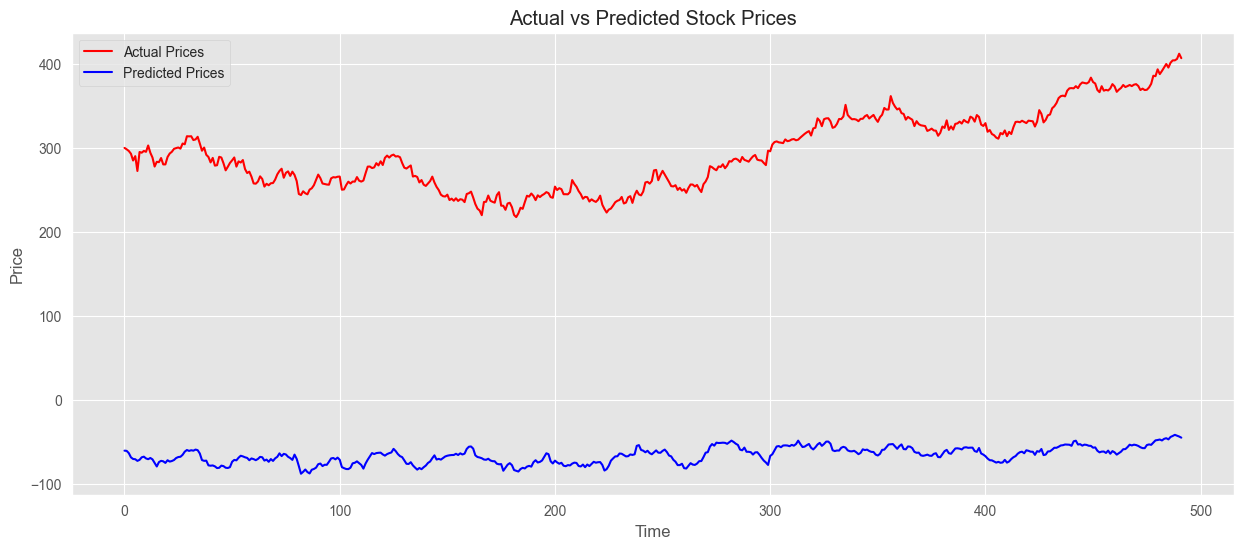

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Calculate metrics
mse = mean_squared_error(actual_prices, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

print("\nFinal Model Performance Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
def save_metrics(test_label, predicted, model_name, stock_name):
    """
    Calculate metrics and save to CSV 
    """
    # Calculate metrics
    mse = mean_squared_error(test_label, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_label, predicted)
    mape = np.mean(np.abs((test_label - predicted) / test_label)) * 100
    r2 = r2_score(test_label, predicted)
    
    # Round to 4 decimal places
    rmse = round(rmse, 4)
    mae = round(mae, 4)
    mape = round(mape, 4)
    r2 = round(r2, 4)
    mse = round(mse, 4)
    
    # Create metrics dictionary
    metrics = {
        'Model': [model_name],
        'Stock': [stock_name],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape],
        'R2': [r2]
    }
    
    # Convert to DataFrame
    df_metrics = pd.DataFrame(metrics)
    
    # Save to CSV
    filename = f'metrics_{model_name}_{stock_name}.csv'
    df_metrics.to_csv(filename, index=False)
    
    # Print metrics
    print(f"\nMetrics for {model_name} on {stock_name}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    print(f"R² Score: {r2:.4f}")

In [44]:
save_metrics(
    test_label=actual_prices,
    predicted=predictions,
    model_name="Transformer-LSTM",
    stock_name="MSFT"  
)


Metrics for Transformer-LSTM on MSFT:
Mean Squared Error (MSE): 131628.2686
Root Mean Squared Error (RMSE): 362.8061
Mean Absolute Error (MAE): 360.6378
Mean Absolute Percentage Error (MAPE): 123.3389%
R² Score: -62.0851


In [45]:
def save_prediction_errors(predictions, actual_values, model_name, stock_name):
    """
    Save prediction errors for error distribution analysis
    """
    # Calculate errors
    errors = predictions - actual_values
    
    # Save to numpy file
    filename = f'errors_{model_name}_{stock_name}.npy'
    np.save(filename, errors)
    
    print(f"Saved prediction errors to {filename}")

# Save the errors
save_prediction_errors(
    predictions=predictions,
    actual_values=actual_prices,
    model_name="Transformer-LSTM",
    stock_name="MSFT" 
)

Saved prediction errors to errors_Transformer-LSTM_MSFT.npy
